In [ ]:
!pip install --upgrade transformers
!pip install --upgrade datasets

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer
)
from sentence_transformers import SentenceTransformer
from transformers import TrainerCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import re
import warnings
import os

In [4]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings("ignore", message="Trainer.tokenizer is now deprecated")
warnings.filterwarnings("ignore", message="A decoder-only architecture is being used, but right-padding was detected")

os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = '1'

# ============= CONFIG =============
MODEL_ID = "Qwen/Qwen3-0.6B"
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
SEMANTIC_THRESHOLD = 0.75
MAX_LENGTH = 512
BATCH_SIZE = 3
EPOCHS =3
LEARNING_RATE = 2e-5

In [5]:
train_df = pd.read_parquet('/kaggle/input/trainingdata/llm_tag_data.parquet')

# Chuyển numpy array thành string (list format)
def tags_to_string(tags):
    if isinstance(tags, np.ndarray):
        tags = tags.tolist()
    return ", ".join(tags[:5])  # Lấy tối đa 5 tags

train_df['tags_str'] = train_df['predicted_tags'].apply(tags_to_string)

train_df = train_df
# Split train/val
train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=42)
print(f"✓ Train: {len(train_data)}, Val: {len(val_data)}")

✓ Train: 2700, Val: 300


In [6]:
class TaggingDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def create_prompt(self, text):
        prompt = f"""You are an expert book classifier.

Task:
Read the book description below and generate **exactly 5** concise and meaningful tags 
that best represent the book's **themes, audience, and literary type**. 
Include the **format** if relevant.

Guidelines:
- Output must contain **exactly 5 tags**, separated by commas and a space.
- Tags should be **general and conceptual** 
- Avoid using **proper names**, **book titles**, **author names**, **award names**, or any phrase appearing directly in the description.
- Do **not** include explanations, numbering, or extra text.
- The output format must strictly be:
  tag1, tag2, tag3, tag4, tag5

Description: "{text}"

Tags:
"""
        return prompt
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Tạo prompt
        prompt = self.create_prompt(row['feature_text'])
        tags = row['tags_str']
        
        # Format theo chat template
        messages = [{"role": "user", "content": prompt}]
        text_input = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            enable_thinking=False
        )
        
        # Thêm output (tags)
        full_text = text_input + tags + self.tokenizer.eos_token
        
        # Tokenize - KHÔNG padding
        encodings = self.tokenizer(
            full_text,
            truncation=True,
            max_length=self.max_length,
            padding=False,
            return_tensors=None,
            add_special_tokens=False  
        )
        
        input_ids = encodings['input_ids']
        attention_mask = encodings['attention_mask']
        
        # Labels: -100 cho phần prompt
        labels = input_ids.copy()
        prompt_tokens = self.tokenizer(
            text_input,
            truncation=True,
            max_length=self.max_length,
            return_tensors=None,
            add_special_tokens=False  # CRITICAL: Consistency
        )['input_ids']
        
        # Mask prompt tokens
        labels[:len(prompt_tokens)] = [-100] * len(prompt_tokens)
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'ground_truth_tags': tags
        }


In [7]:
from dataclasses import dataclass
from typing import Any, Dict, List
import torch

@dataclass
class CustomDataCollator:
    """Custom collator để xử lý ground_truth_tags riêng"""
    tokenizer: AutoTokenizer
    
    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        ground_truth_tags = [f.pop('ground_truth_tags') for f in features]
        max_length = max(len(f['input_ids']) for f in features)
        
        batch_input_ids = []
        batch_attention_mask = []
        batch_labels = []
        
        #Đảm bảo pad_token_id hợp lệ
        pad_token_id = self.tokenizer.pad_token_id
        if pad_token_id is None:
            pad_token_id = self.tokenizer.eos_token_id
        
        #Padding bên TRÁI 
        for f in features:
            padding_length = max_length - len(f['input_ids'])
            # Left padding
            batch_input_ids.append([pad_token_id] * padding_length + f['input_ids'])
            batch_attention_mask.append([0] * padding_length + f['attention_mask'])
            batch_labels.append([-100] * padding_length + f['labels'])
        
        return {
            'input_ids': torch.tensor(batch_input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(batch_attention_mask, dtype=torch.long),
            'labels': torch.tensor(batch_labels, dtype=torch.long),
            'ground_truth_tags': ground_truth_tags
        }

In [8]:
class SemanticLossTrainer(Trainer):
    def __init__(self, *args, embedding_model_name="BAAI/bge-small-en-v1.5", 
                 semantic_threshold=0.7, **kwargs):
        super().__init__(*args, **kwargs)
        self.embedding_model = SentenceTransformer(embedding_model_name)
        self.semantic_threshold = semantic_threshold
        self.semantic_loss_enabled = True
        
    def parse_tags(self, text):
        text = text.strip()
        tags = [t.strip() for t in text.split(',')]
        return tags[:5]
    
    def compute_semantic_similarity(self, pred_tags, true_tags):
        if not pred_tags or not true_tags:
            return 0.0
        
        pred_embeds = self.embedding_model.encode(pred_tags, show_progress_bar=False)
        true_embeds = self.embedding_model.encode(true_tags, show_progress_bar=False)
        
        similarities = cosine_similarity(
            pred_embeds.reshape(len(pred_tags), -1),
            true_embeds.reshape(len(true_tags), -1)
        )
        
        max_sims = similarities.max(axis=1)
        correct_ratio = (max_sims >= self.semantic_threshold).mean()
        
        return correct_ratio
    
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        ground_truth_tags = inputs.get('ground_truth_tags', None)
        outputs = model(**inputs)
        lm_loss = outputs.loss
        
        num_samples = min(2, inputs['input_ids'].shape[0])
        
        try:
            with torch.no_grad():
                sample_input_ids = inputs['input_ids'][:num_samples]
                sample_attention_mask = inputs['attention_mask'][:num_samples]
                
                generated_ids = model.generate(
                    input_ids=sample_input_ids,
                    attention_mask=sample_attention_mask,
                    max_new_tokens=60,
                    do_sample=False,
                    pad_token_id=self.processing_class.pad_token_id,
                    num_return_sequences=1
                )
                
                pred_texts = self.processing_class.batch_decode(
                    generated_ids[:, sample_input_ids.shape[1]:],
                    skip_special_tokens=True
                )
                
                semantic_scores = []
                for pred_text, true_tags in zip(pred_texts, ground_truth_tags[:num_samples]):
                    pred_tags = self.parse_tags(pred_text)
                    true_tags_list = self.parse_tags(true_tags)
                    score = self.compute_semantic_similarity(pred_tags, true_tags_list)
                    semantic_scores.append(score)
                
                if semantic_scores:
                    avg_semantic_score = np.mean(semantic_scores)
                    semantic_loss = 1.0 - avg_semantic_score
                    semantic_loss = torch.tensor(semantic_loss, device=lm_loss.device)
                else:
                    semantic_loss = torch.tensor(0.0, device=lm_loss.device)
                
        except Exception as e:
            semantic_loss = torch.tensor(0.0, device=lm_loss.device)
        
        total_loss = lm_loss + 0.5 * semantic_loss
        return (total_loss, outputs) if return_outputs else total_loss
    
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        """
        Override prediction_step để tính toán loss tương tự như trong training
        """
        has_labels = all(inputs.get(k) is not None for k in self.label_names)
        
        # Loại bỏ ground_truth_tags khỏi inputs để tránh lỗi
        ground_truth_tags = inputs.pop('ground_truth_tags', None)
        
        # Tính loss với semantic component
        inputs['ground_truth_tags'] = ground_truth_tags
        
        with torch.no_grad():
            if has_labels:
                loss, outputs = self.compute_loss(model, inputs, return_outputs=True)
                loss = loss.mean().detach()
            else:
                loss = None
                outputs = model(**inputs)
        
        if prediction_loss_only:
            return (loss, None, None)
        
        # Lấy logits và labels
        logits = outputs.logits if hasattr(outputs, 'logits') else None
        labels = inputs.get('labels')
        
        # Detach logits nếu có
        if logits is not None:
            logits = logits.detach()
        
        # Detach labels nếu có
        if labels is not None:
            labels = labels.detach()
        
        return (loss, logits, labels)

In [9]:
print("⏳ Loading model and tokenizer...")
# save_dir = "./qwen3-tag-final"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, padding_side='left')
# tokenizer = AutoTokenizer.from_pretrained(save_dir, padding_side='left')

# FIX: Thiết lập pad_token đúng cách
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float32,  # ✅ Thay vì float16
    device_map="auto",
    use_cache=False
)
# model = AutoModelForCausalLM.from_pretrained(save_dir)
# FIX: Resize token embeddings nếu cần
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

# Enable gradient checkpointing
model.gradient_checkpointing_enable()
print("✓ Model loaded successfully")
print(f"✓ Vocab size: {len(tokenizer)}, Pad token ID: {tokenizer.pad_token_id}")

# ============= CREATE DATASETS =============
print("⏳ Preparing datasets...")
train_dataset = TaggingDataset(train_data, tokenizer, MAX_LENGTH)
val_dataset = TaggingDataset(val_data, tokenizer, MAX_LENGTH)
print("✓ Datasets ready")


# ============= TRAINING ARGUMENTS =============
training_args = TrainingArguments(
    output_dir="./qwen3-tag-finetuned",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    warmup_steps=100,
    
    logging_dir="./logs",
    report_to=["tensorboard"],
    logging_steps=30,
    logging_first_step=True,
    
    eval_strategy="steps",
    eval_steps=150,
    
    save_strategy="steps",
    save_steps=150,
    save_only_model=True,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    
    bf16=False,
    fp16=False,
    dataloader_num_workers=3,
    
    disable_tqdm=False,
    
    remove_unused_columns=False,
    prediction_loss_only=True,
)

# ============= TRAIN MODEL =============
data_collator = CustomDataCollator(tokenizer=tokenizer)

trainer = SemanticLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    data_collator=data_collator,
    embedding_model_name=EMBEDDING_MODEL,
    semantic_threshold=SEMANTIC_THRESHOLD,
)

print("\n" + "="*60)
print("🚀 STARTING TRAINING")
print("="*60)
print(f"📊 Total epochs: {EPOCHS}")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"🔄 Gradient accumulation: 4")
print(f"📈 Effective batch size: {BATCH_SIZE * 4}")
print(f"🎯 Learning rate: {LEARNING_RATE}")
print(f"💾 Training samples: {len(train_dataset)}")
print(f"🔍 Validation samples: {len(val_dataset)}")
print("="*60 + "\n")

trainer.semantic_loss_enabled = True
trainer.train()

⏳ Loading model and tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


✓ Model loaded successfully
✓ Vocab size: 151669, Pad token ID: 151643
⏳ Preparing datasets...
✓ Datasets ready


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.



🚀 STARTING TRAINING
📊 Total epochs: 3
📦 Batch size: 3
🔄 Gradient accumulation: 4
📈 Effective batch size: 12
🎯 Learning rate: 2e-05
💾 Training samples: 2700
🔍 Validation samples: 300



The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
Caching is incompatible with gradient checkpointing in Qwen3DecoderLayer. Setting `past_key_values=None`.


Step,Training Loss,Validation Loss
150,7.482300,1.780284
300,4.812800,1.613434
450,4.887600,1.529233
600,3.245700,1.604920


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

TrainOutput(global_step=675, training_loss=5.237167452074977, metrics={'train_runtime': 11290.6951, 'train_samples_per_second': 0.717, 'train_steps_per_second': 0.06, 'total_flos': 1.0084998371475456e+16, 'train_loss': 5.237167452074977, 'epoch': 3.0})

In [10]:
%load_ext tensorboard

In [11]:
%tensorboard --logdir /kaggle/working/logs

<IPython.core.display.Javascript object>

In [12]:
from tensorboard import notebook

# Display TensorBoard đang chạy
notebook.display(port=6006, height=800)

Selecting TensorBoard with logdir /kaggle/working/logs (started 0:00:01 ago; port 6006, pid 308).


<IPython.core.display.Javascript object>

Reading TensorBoard logs...
Reading: /kaggle/working/logs/events.out.tfevents.1764950730.f176282b8ed0.95.0

Found 13 metrics:
  - train/loss: 23 data points
  - train/grad_norm: 23 data points
  - train/learning_rate: 23 data points
  - train/epoch: 28 data points
  - eval/loss: 4 data points
  - eval/runtime: 4 data points
  - eval/samples_per_second: 4 data points
  - eval/steps_per_second: 4 data points
  - train/train_runtime: 1 data points
  - train/train_samples_per_second: 1 data points
  - train/train_steps_per_second: 1 data points
  - train/total_flos: 1 data points
  - train/train_loss: 1 data points


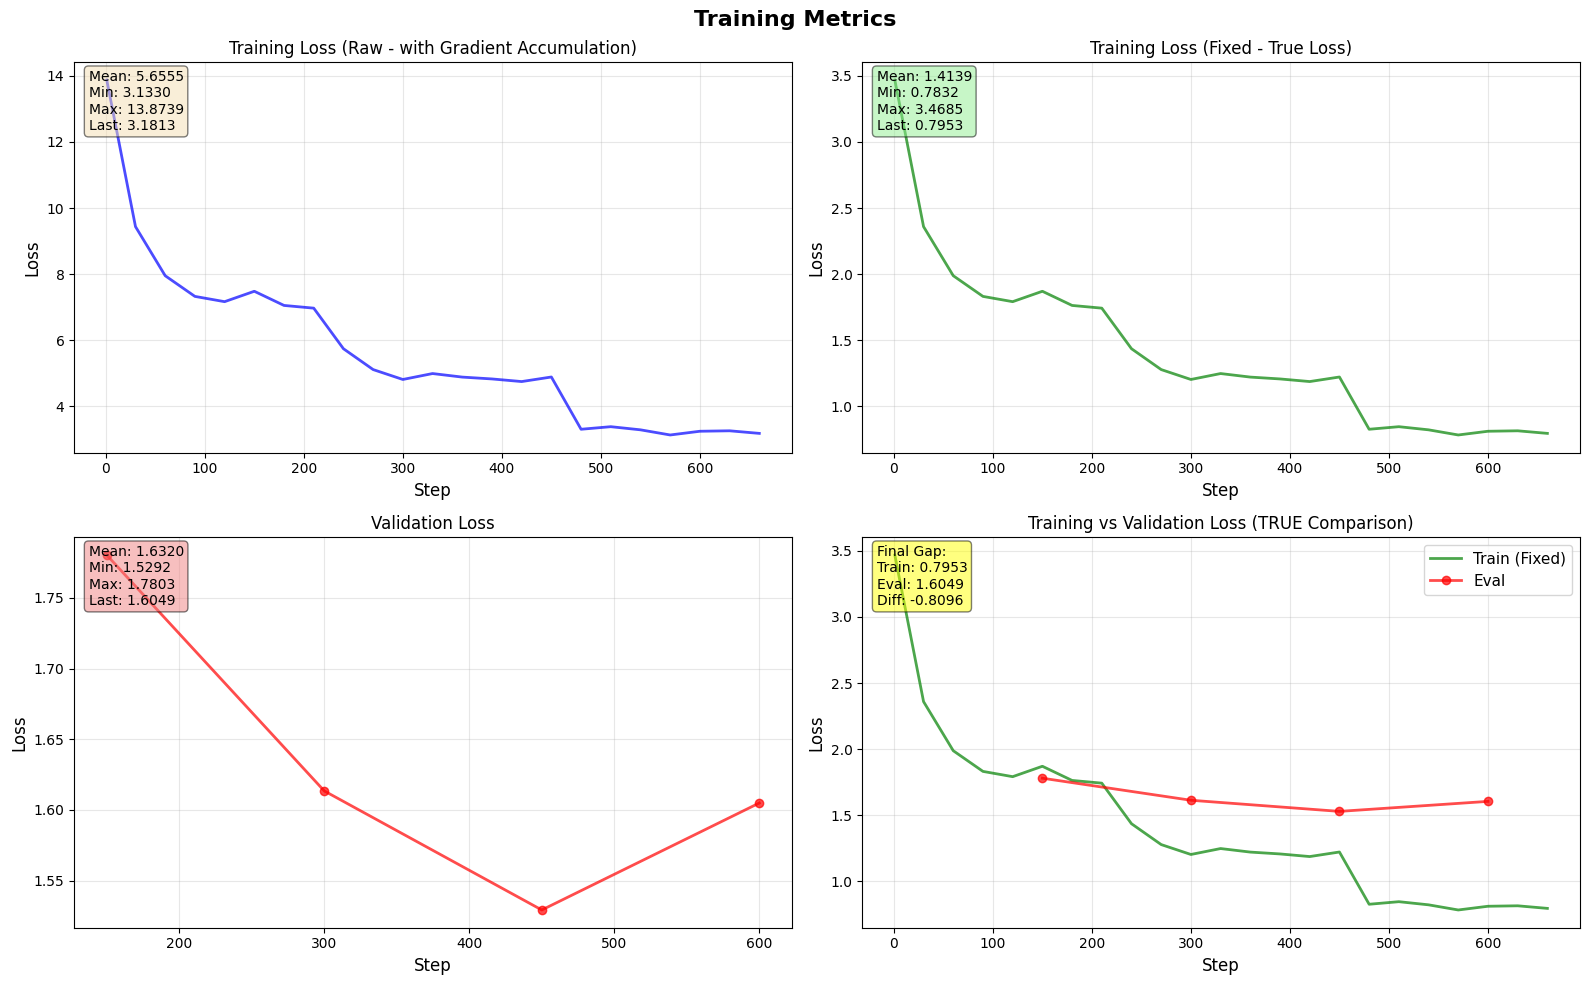


SUMMARY

train/loss (Fixed):
  Steps: 23
  Mean:  1.4139
  Min:   0.7832
  Max:   3.4685
  First: 3.4685
  Last:  0.7953

train/grad_norm (Fixed):
  Steps: 23
  Mean:  24.0308
  Min:   12.5030
  Max:   131.1298
  First: 131.1298
  Last:  18.5553

train/learning_rate (Fixed):
  Steps: 23
  Mean:  0.0000
  Min:   0.0000
  Max:   0.0000
  First: 0.0000
  Last:  0.0000

train/epoch (Fixed):
  Steps: 28
  Mean:  0.3875
  Min:   0.0011
  Max:   0.7500
  First: 0.0011
  Last:  0.7500

eval/loss:
  Steps: 4
  Mean:  1.6320
  Min:   1.5292
  Max:   1.7803
  First: 1.7803
  Last:  1.6049

eval/runtime:
  Steps: 4
  Mean:  128.3973
  Min:   128.2869
  Max:   128.4595
  First: 128.4115
  Last:  128.2869

eval/samples_per_second:
  Steps: 4
  Mean:  2.3365
  Min:   2.3350
  Max:   2.3390
  First: 2.3360
  Last:  2.3390

eval/steps_per_second:
  Steps: 4
  Mean:  0.7790
  Min:   0.7780
  Max:   0.7800
  First: 0.7790
  Last:  0.7800

train/train_runtime (Fixed):
  Steps: 1
  Mean:  2822.6738
  Min:

In [13]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
import matplotlib.pyplot as plt
import pandas as pd

def extract_tensorboard_scalars(log_dir):
    """Đọc tất cả scalar values từ TensorBoard logs"""
    import os
    from collections import defaultdict
    
    scalar_data = defaultdict(list)
    
    # Tìm tất cả event files
    for root, dirs, files in os.walk(log_dir):
        for filename in files:
            if 'events.out.tfevents' in filename:
                filepath = os.path.join(root, filename)
                print(f"Reading: {filepath}")
                
                try:
                    for event in summary_iterator(filepath):
                        if event.HasField('summary'):
                            for value in event.summary.value:
                                if value.HasField('simple_value'):
                                    scalar_data[value.tag].append({
                                        'step': event.step,
                                        'value': value.simple_value,
                                        'wall_time': event.wall_time
                                    })
                except Exception as e:
                    print(f"Error reading {filepath}: {e}")
    
    # Convert to DataFrames
    scalar_dfs = {}
    for tag, data in scalar_data.items():
        scalar_dfs[tag] = pd.DataFrame(data).sort_values('step')
    
    return scalar_dfs

# Đọc logs
print("Reading TensorBoard logs...")
scalar_dfs = extract_tensorboard_scalars('/kaggle/working/logs')

print(f"\nFound {len(scalar_dfs)} metrics:")
for tag in scalar_dfs.keys():
    print(f"  - {tag}: {len(scalar_dfs[tag])} data points")

# Plot loss curves
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Training Metrics', fontsize=16, fontweight='bold')

# 1. Training Loss (Raw)
if 'train/loss' in scalar_dfs or 'loss' in scalar_dfs:
    ax = axes[0, 0]
    train_key = 'train/loss' if 'train/loss' in scalar_dfs else 'loss'
    df = scalar_dfs[train_key]
    ax.plot(df['step'], df['value'], 'b-', linewidth=2, alpha=0.7)
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Training Loss (Raw - with Gradient Accumulation)', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Statistics
    stats_text = f"Mean: {df['value'].mean():.4f}\nMin: {df['value'].min():.4f}\nMax: {df['value'].max():.4f}\nLast: {df['value'].iloc[-1]:.4f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Training Loss (Fixed)
if 'train/loss' in scalar_dfs or 'loss' in scalar_dfs:
    ax = axes[0, 1]
    train_key = 'train/loss' if 'train/loss' in scalar_dfs else 'loss'
    df = scalar_dfs[train_key].copy()
    df['value'] = df['value'] / 4  # Fix gradient accumulation
    ax.plot(df['step'], df['value'], 'g-', linewidth=2, alpha=0.7)
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Training Loss (Fixed - True Loss)', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    stats_text = f"Mean: {df['value'].mean():.4f}\nMin: {df['value'].min():.4f}\nMax: {df['value'].max():.4f}\nLast: {df['value'].iloc[-1]:.4f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# 3. Validation Loss
if 'eval/loss' in scalar_dfs or 'eval_loss' in scalar_dfs:
    ax = axes[1, 0]
    eval_key = 'eval/loss' if 'eval/loss' in scalar_dfs else 'eval_loss'
    df = scalar_dfs[eval_key]
    ax.plot(df['step'], df['value'], 'r-', linewidth=2, marker='o', markersize=6, alpha=0.7)
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Validation Loss', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    stats_text = f"Mean: {df['value'].mean():.4f}\nMin: {df['value'].min():.4f}\nMax: {df['value'].max():.4f}\nLast: {df['value'].iloc[-1]:.4f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

# 4. Train vs Eval (Fixed)
ax = axes[1, 1]
if 'train/loss' in scalar_dfs or 'loss' in scalar_dfs:
    train_key = 'train/loss' if 'train/loss' in scalar_dfs else 'loss'
    df_train = scalar_dfs[train_key].copy()
    df_train['value'] = df_train['value'] / 4  # Fix
    ax.plot(df_train['step'], df_train['value'], 'g-', linewidth=2, alpha=0.7, label='Train (Fixed)')

if 'eval/loss' in scalar_dfs or 'eval_loss' in scalar_dfs:
    eval_key = 'eval/loss' if 'eval/loss' in scalar_dfs else 'eval_loss'
    df_eval = scalar_dfs[eval_key]
    ax.plot(df_eval['step'], df_eval['value'], 'r-', linewidth=2, marker='o', markersize=6, alpha=0.7, label='Eval')

ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training vs Validation Loss (TRUE Comparison)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Gap analysis
if ('train/loss' in scalar_dfs or 'loss' in scalar_dfs) and ('eval/loss' in scalar_dfs or 'eval_loss' in scalar_dfs):
    train_last = df_train['value'].iloc[-1]
    eval_last = df_eval['value'].iloc[-1]
    gap = train_last - eval_last
    gap_text = f"Final Gap:\nTrain: {train_last:.4f}\nEval: {eval_last:.4f}\nDiff: {gap:.4f}"
    ax.text(0.02, 0.98, gap_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

for tag, df in scalar_dfs.items():
    # Fix train loss
    if 'train' in tag.lower() or tag == 'loss':
        df = df.copy()
        df['value'] = df['value'] / 4
        tag = f"{tag} (Fixed)"
    
    print(f"\n{tag}:")
    print(f"  Steps: {len(df)}")
    print(f"  Mean:  {df['value'].mean():.4f}")
    print(f"  Min:   {df['value'].min():.4f}")
    print(f"  Max:   {df['value'].max():.4f}")
    print(f"  First: {df['value'].iloc[0]:.4f}")
    print(f"  Last:  {df['value'].iloc[-1]:.4f}")

print("\n" + "="*80)

In [ ]:
def generate_tags(text, model, tokenizer):
    """
    Fixed inference function với proper error handling
    """
    prompt = f"""You are an expert book classifier.

Task:
Read the book description below and generate **exactly 5** concise and meaningful tags 
that best represent the book's **themes, audience, and literary type**. 
Include the **format** if relevant.

Guidelines:
- Output must contain **exactly 5 tags**, separated by commas and a space.
- Tags should be **general and conceptual** 
- Avoid using **proper names**, **book titles**, **author names**, **award names**, or any phrase appearing directly in the description.
- Do **not** include explanations, numbering, or extra text.
- The output format must strictly be:
  tag1, tag2, tag3, tag4, tag5

Description: "{text}"

Tags:
"""
    
    messages = [{"role": "user", "content": prompt}]
    text_input = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False
    )
    
    # FIX: Đúng cách tokenize và move to device
    inputs = tokenizer(text_input, return_tensors="pt", add_special_tokens=False)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Set model to eval mode
    model.eval()
    
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=60,
            do_sample=True,
            temperature=0.2,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    # Decode only the generated part
    response = tokenizer.decode(
        generated_ids[0, inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    ).strip()
    
    return response

# ============= TEST INFERENCE =============
print("\n" + "="*50)
print("TEST INFERENCE")
print("="*50)

# Clear CUDA cache before testing
torch.cuda.empty_cache()

test_text = val_data.iloc[0]['feature_text']
test_tags = val_data.iloc[0]['tags_str']

print(f"Input text: {test_text}...")
print(f"\nGround truth tags: {test_tags}")

try:
    generated = generate_tags(test_text, model, tokenizer)
    print(f"\nGenerated tags: {generated}")
except Exception as e:
    print(f"\n❌ Error during generation: {e}")
    print("\nTrying with CUDA_LAUNCH_BLOCKING for debugging...")
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    torch.cuda.empty_cache()
    generated = generate_tags(test_text, model, tokenizer)
    print(f"\nGenerated tags: {generated}")

In [ ]:
save_dir = "./qwen3-tag-semantic-final"

trainer.model.save_pretrained(save_dir)
trainer.tokenizer.save_pretrained(save_dir)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(save_dir)
tokenizer = AutoTokenizer.from_pretrained(save_dir)

In [ ]:
def generate_tags(text, model, tokenizer):
    """
    Fixed inference function với proper error handling
    """
    prompt = f"""You are an expert book classifier.

Task:
Read the book description below and generate **exactly 5** concise and meaningful tags 
that best represent the book's **themes, audience, and literary type**. 
Include the **format** if relevant.

Guidelines:
- Output must contain **exactly 5 tags**, separated by commas and a space.
- Tags should be **general and conceptual** 
- Avoid using **proper names**, **book titles**, **author names**, **award names**, or any phrase appearing directly in the description.
- Do **not** include explanations, numbering, or extra text.
- The output format must strictly be:
  tag1, tag2, tag3, tag4, tag5

Description: "{text}"

Tags:
"""
    
    messages = [{"role": "user", "content": prompt}]
    text_input = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False
    )
    
    # FIX: Đúng cách tokenize và move to device
    inputs = tokenizer(text_input, return_tensors="pt", add_special_tokens=False)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Set model to eval mode
    model.eval()
    
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=60,
            do_sample=True,
            temperature=0.2,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    # Decode only the generated part
    response = tokenizer.decode(
        generated_ids[0, inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    ).strip()
    
    return response

# ============= TEST INFERENCE =============
print("\n" + "="*50)
print("TEST INFERENCE")
print("="*50)

# Clear CUDA cache before testing
torch.cuda.empty_cache()

test_text = val_data.iloc[0]['feature_text']
test_tags = val_data.iloc[0]['tags_str']

print(f"Input text: {test_text}...")
print(f"\nGround truth tags: {test_tags}")

try:
    generated = generate_tags(test_text, model, tokenizer)
    print(f"\nGenerated tags: {generated}")
except Exception as e:
    print(f"\n❌ Error during generation: {e}")
    print("\nTrying with CUDA_LAUNCH_BLOCKING for debugging...")
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    torch.cuda.empty_cache()
    generated = generate_tags(test_text, model, tokenizer)
    print(f"\nGenerated tags: {generated}")